In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import math
import statistics as st
import heapq
import operator
import errno
from zxcvbn import zxcvbn
from itertools import islice
#from password_strength import PasswordStats
import argparse
from mpl_toolkits.mplot3d import Axes3D
import re
from Levenshtein import distance as levenshtein_distance
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from itertools import cycle
import itertools
from collections import OrderedDict

In [54]:
def mkdir_p(path):
    """To make a directory given a path."""
    try:
        os.makedirs(path)
    except OSError as exc:  # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise
            
def unpack_data(res_folder=None):
    g = []
    br = False
    files = os.listdir(res_folder)
    for file_name in files:
        print(file_name)
        file_path = os.path.join(res_folder, file_name)
        h = pickle.load(open(file_path, 'rb'))
        g.append(h)
        if br:
            break
    
    print('Read Disk')
    print('{} TEST RUNS FOUND'.format(len(g)))

    return g

def get_auc(member_scores, non_member_scores):
    member_scores_avg = [np.mean(np.array(t)) for t in list(zip(*member_scores))]
    non_member_scores_avg = [np.mean(np.array(t)) for t in list(zip(*non_member_scores))]
    y_true_member = [1 for _ in range(len(member_scores_avg))]
    y_true_non_member = [0 for _ in range(len(non_member_scores_avg))]
    y_true = y_true_member + y_true_non_member

    y_probas = member_scores_avg + non_member_scores_avg
    fpr, tpr, threshold = roc_curve(y_true, y_probas)
    auc = roc_auc_score(y_true, y_probas)
    #print('roc_auc_score: ', roc_auc_score(y_true, y_probas))
    
    return auc, fpr, tpr

def plot_roc(auc, fpr, tpr):
    fig = plt.figure(num=None, figsize=(6, 3.2), dpi=500, facecolor='w', edgecolor='k')
    plt.plot(fpr, tpr, label="AUC={0:.2f}".format(auc))
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend()
    plt.show()
    
def plot_multiple_auc_lines(aucs_per_epoch, plot_name, plt_folder, total_avg_loss, total_secret_f1, total_epoch_scores, entity):
    plt.figure(num=None, figsize=(6, 3.2), dpi=500, facecolor='w', edgecolor='k')
    return_list = []
    fig, ax1 = plt.subplots(num=None, figsize=(6, 3.2), dpi=500, facecolor='w', edgecolor='k')
    
    marker_size = 3
    mark_every = 0.05
    
    
    linestyles_dict = OrderedDict(
    [('solid',               (0, ())),
     ('loosely dotted',      (0, (1, 10))),
     ('dotted',              (0, (1, 5))),
     ('densely dotted',      (0, (1, 1))),

     ('loosely dashed',      (0, (5, 10))),
     ('dashed',              (0, (5, 5))),
     ('densely dashed',      (0, (5, 1))),

     ('loosely dashdotted',  (0, (3, 10, 1, 10))),
     ('dashdotted',          (0, (3, 5, 1, 5))),
     ('densely dashdotted',  (0, (3, 1, 1, 1))),

     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))])
    
    lines = ["-","--","-.",":", 'None']
    linestype = itertools.cycle(("densely dashed", "dashed", "dashdotted", "densely dotted", "densely dashdotted", "dashdotdotted", "solid"))
    marker = itertools.cycle(('s', 'o', 'p', 'D', 'h', 'v', '^', '>', '<', '1')) 

    
    plts = []
    for auc_per_epoch in aucs_per_epoch:
        epochs = list(auc_per_epoch[0].keys())
        aucs = list(auc_per_epoch[0].values())
        entity = auc_per_epoch[1]
        
#         ax1.plot(epochs, aucs, linestyle=linestyles_dict[next(linestype)], label=entity+" AUC")
        pl = ax1.plot(epochs, aucs, next(marker), label=entity+" AUC", markevery=mark_every, markersize=marker_size, linestyle=linestyles_dict[next(linestype)])
        plts.extend(pl)
        return_list.append([entity, pl])
        
    # pl1 = ax1.plot(epochs, total_epoch_scores, color='green', label="Overall test F1-score", marker=next(marker), markevery=mark_every, markersize=marker_size)
    pl2 = ax1.plot(epochs, total_secret_f1, color='red', label="Entity test F1-score", marker=next(marker), markevery=mark_every, markersize=marker_size)
    ax1.set_ylabel("AUC/F1")
    ax1.set_xlabel("Epochs")
    
    ax1.set_ylim([0.25, 1])
    
#     ax2 = ax1.twinx()
    
#     pl3 = ax2.plot(epochs, total_avg_loss, color='grey', label="Training Loss", alpha=0.5, marker=next(marker), markevery=mark_every, markersize=marker_size)
#     ax2.set_ylabel("NER Loss")
    
    #leg1 = ax1.legend(prop={'size': 7}, loc="lower right", ncol=2, frameon=False)
    #leg2 = ax2.legend(prop={'size': 8}, loc="upper right", ncol=2, frameon=False)
    
    # plts.extend(pl1)
    plts.extend(pl2)
    if 'DUMMY' in entity:
        return_list.append(['Entity test F1-score - DUMMY', pl2])
    else:
        return_list.append(['Entity test F1-score', pl2])
#     plts.extend(pl3)
    
    print(plts)
    labs = [l.get_label() for l in plts]
    
    ax1.legend(plts, labs, loc="lower right", ncol=2, frameon=False, prop={'size': 8})
    
    fig.tight_layout()
    plt_dest = plt_folder + plot_name
    plt.savefig(plt_dest,
            bbox_inches="tight")
    
    # plt.show()

    return return_list
    
def plot_auc_line(auc_per_epoch, plot_name, plt_folder, total_avg_loss, avg_secret_f1, avg_epoch_scores, entity):
    plt.figure(num=None, figsize=(6, 3.2), dpi=500, facecolor='w', edgecolor='k')
    
    fig, ax1 = plt.subplots(num=None, figsize=(6, 3.2), dpi=500, facecolor='w', edgecolor='k')
    
    lines = ["-","--","-.",":", 'None']
    linestype = itertools.cycle(("-","--","-.",":"))
    marker = itertools.cycle(('v', '+', '>', 'o', '*','^')) 

    #for auc_per_epoch in aucs_per_epoch:
    epochs = list(auc_per_epoch[0].keys())
    aucs = list(auc_per_epoch[0].values())
    entity = auc_per_epoch[1]

    ax1.plot(epochs, aucs, next(linestype), label=entity+" AUC")
    ax1.plot(epochs, avg_epoch_scores, next(linestype), color='green', label="F1-score")
    ax1.plot(epochs, avg_secret_f1, next(linestype), color='red', label="{} F1-score".format(entity))
    
    ax1.set_ylabel("AUC/F1")
    ax1.set_xlabel("Epochs")
    
    ax2 = ax1.twinx()
    
    ax2.plot(epochs, total_avg_loss, next(linestype), color='grey', label="Training Loss")
    
    ax2.set_ylabel("NER Loss")
    
    ax1.legend(prop={'size': 6}, loc="center right")
    ax2.legend(prop={'size': 6}, loc="lower right")
    
    fig.tight_layout()
    plt_dest = plt_folder + plot_name
    plt.savefig(plt_dest,
            bbox_inches="tight")
    
def plot_loss_line(epochs, losses):
    plt.figure(num=None, figsize=(6, 3.2), dpi=500, facecolor='w', edgecolor='k')
    plt.plot(epochs, losses, '-')
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.show()
    
def get_auc_per_epoch(member_scores_per_epoch, non_member_scores_per_epoch):
    avg_member_scores_per_epoch = {epoch:[] for epoch in member_scores_per_epoch[0].keys()}
    avg_non_member_scores_per_epoch = {epoch:[] for epoch in non_member_scores_per_epoch[0].keys()}

    for sub_run in range(len(member_scores_per_epoch)):
        for epoch in range(1,epochs+1):
            avg_member_scores_per_epoch[epoch].append(member_scores_per_epoch[sub_run][epoch])
            avg_non_member_scores_per_epoch[epoch].append(non_member_scores_per_epoch[sub_run][epoch])

    auc_per_epoch = {}
    for epoch in range(1,epochs+1):
        auc, fpr, tpr = get_auc(avg_member_scores_per_epoch[epoch], avg_non_member_scores_per_epoch[epoch])
        auc_per_epoch[epoch] = auc
        #plot_roc(auc, fpr, tpr)
        
    return auc_per_epoch

en_core_web_lg_results_label_None.pickle3
Read Disk
1 TEST RUNS FOUND
en_core_web_lg_results_label_None.pickle3
Read Disk
1 TEST RUNS FOUND
[<matplotlib.lines.Line2D object at 0x7f9e52f779e8>, <matplotlib.lines.Line2D object at 0x7f9e52f779b0>, <matplotlib.lines.Line2D object at 0x7f9e52f772b0>]
en_core_web_lg_results_label_None.pickle3
Read Disk
1 TEST RUNS FOUND
en_core_web_lg_results_label_None.pickle3
Read Disk
1 TEST RUNS FOUND
[<matplotlib.lines.Line2D object at 0x7f9e1de67908>, <matplotlib.lines.Line2D object at 0x7f9e1de67940>, <matplotlib.lines.Line2D object at 0x7f9e1de678d0>]


<Figure size 3000x1600 with 0 Axes>

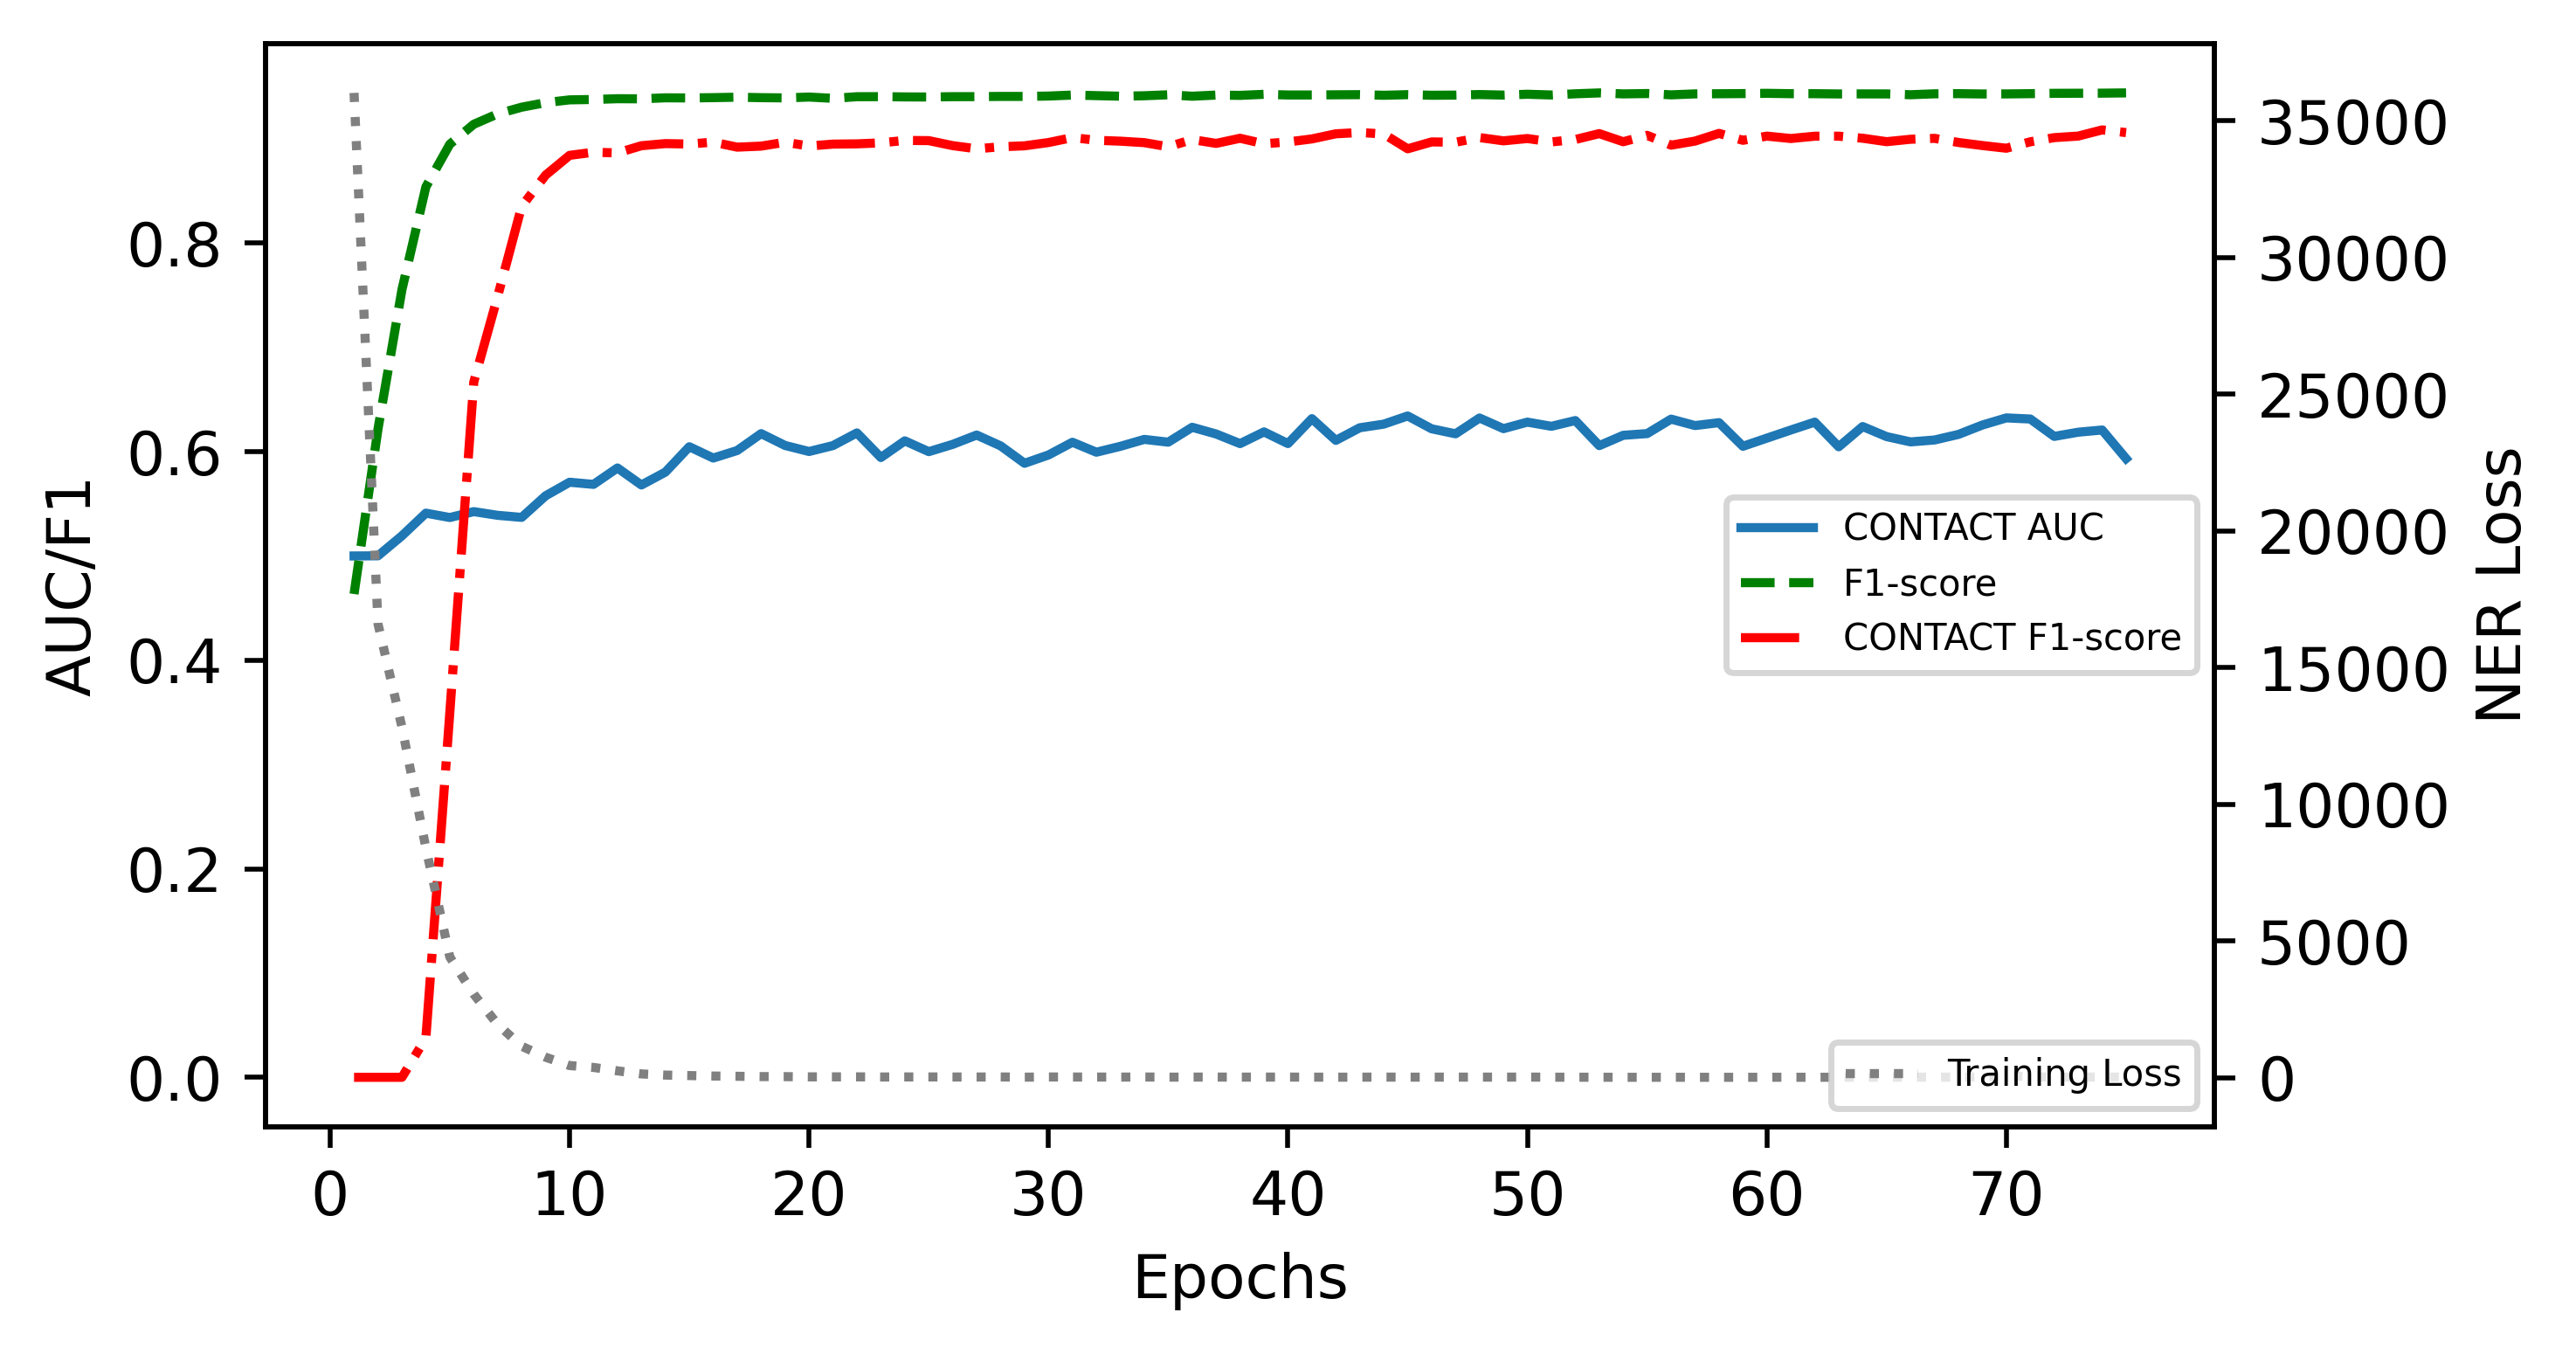

<Figure size 3000x1600 with 0 Axes>

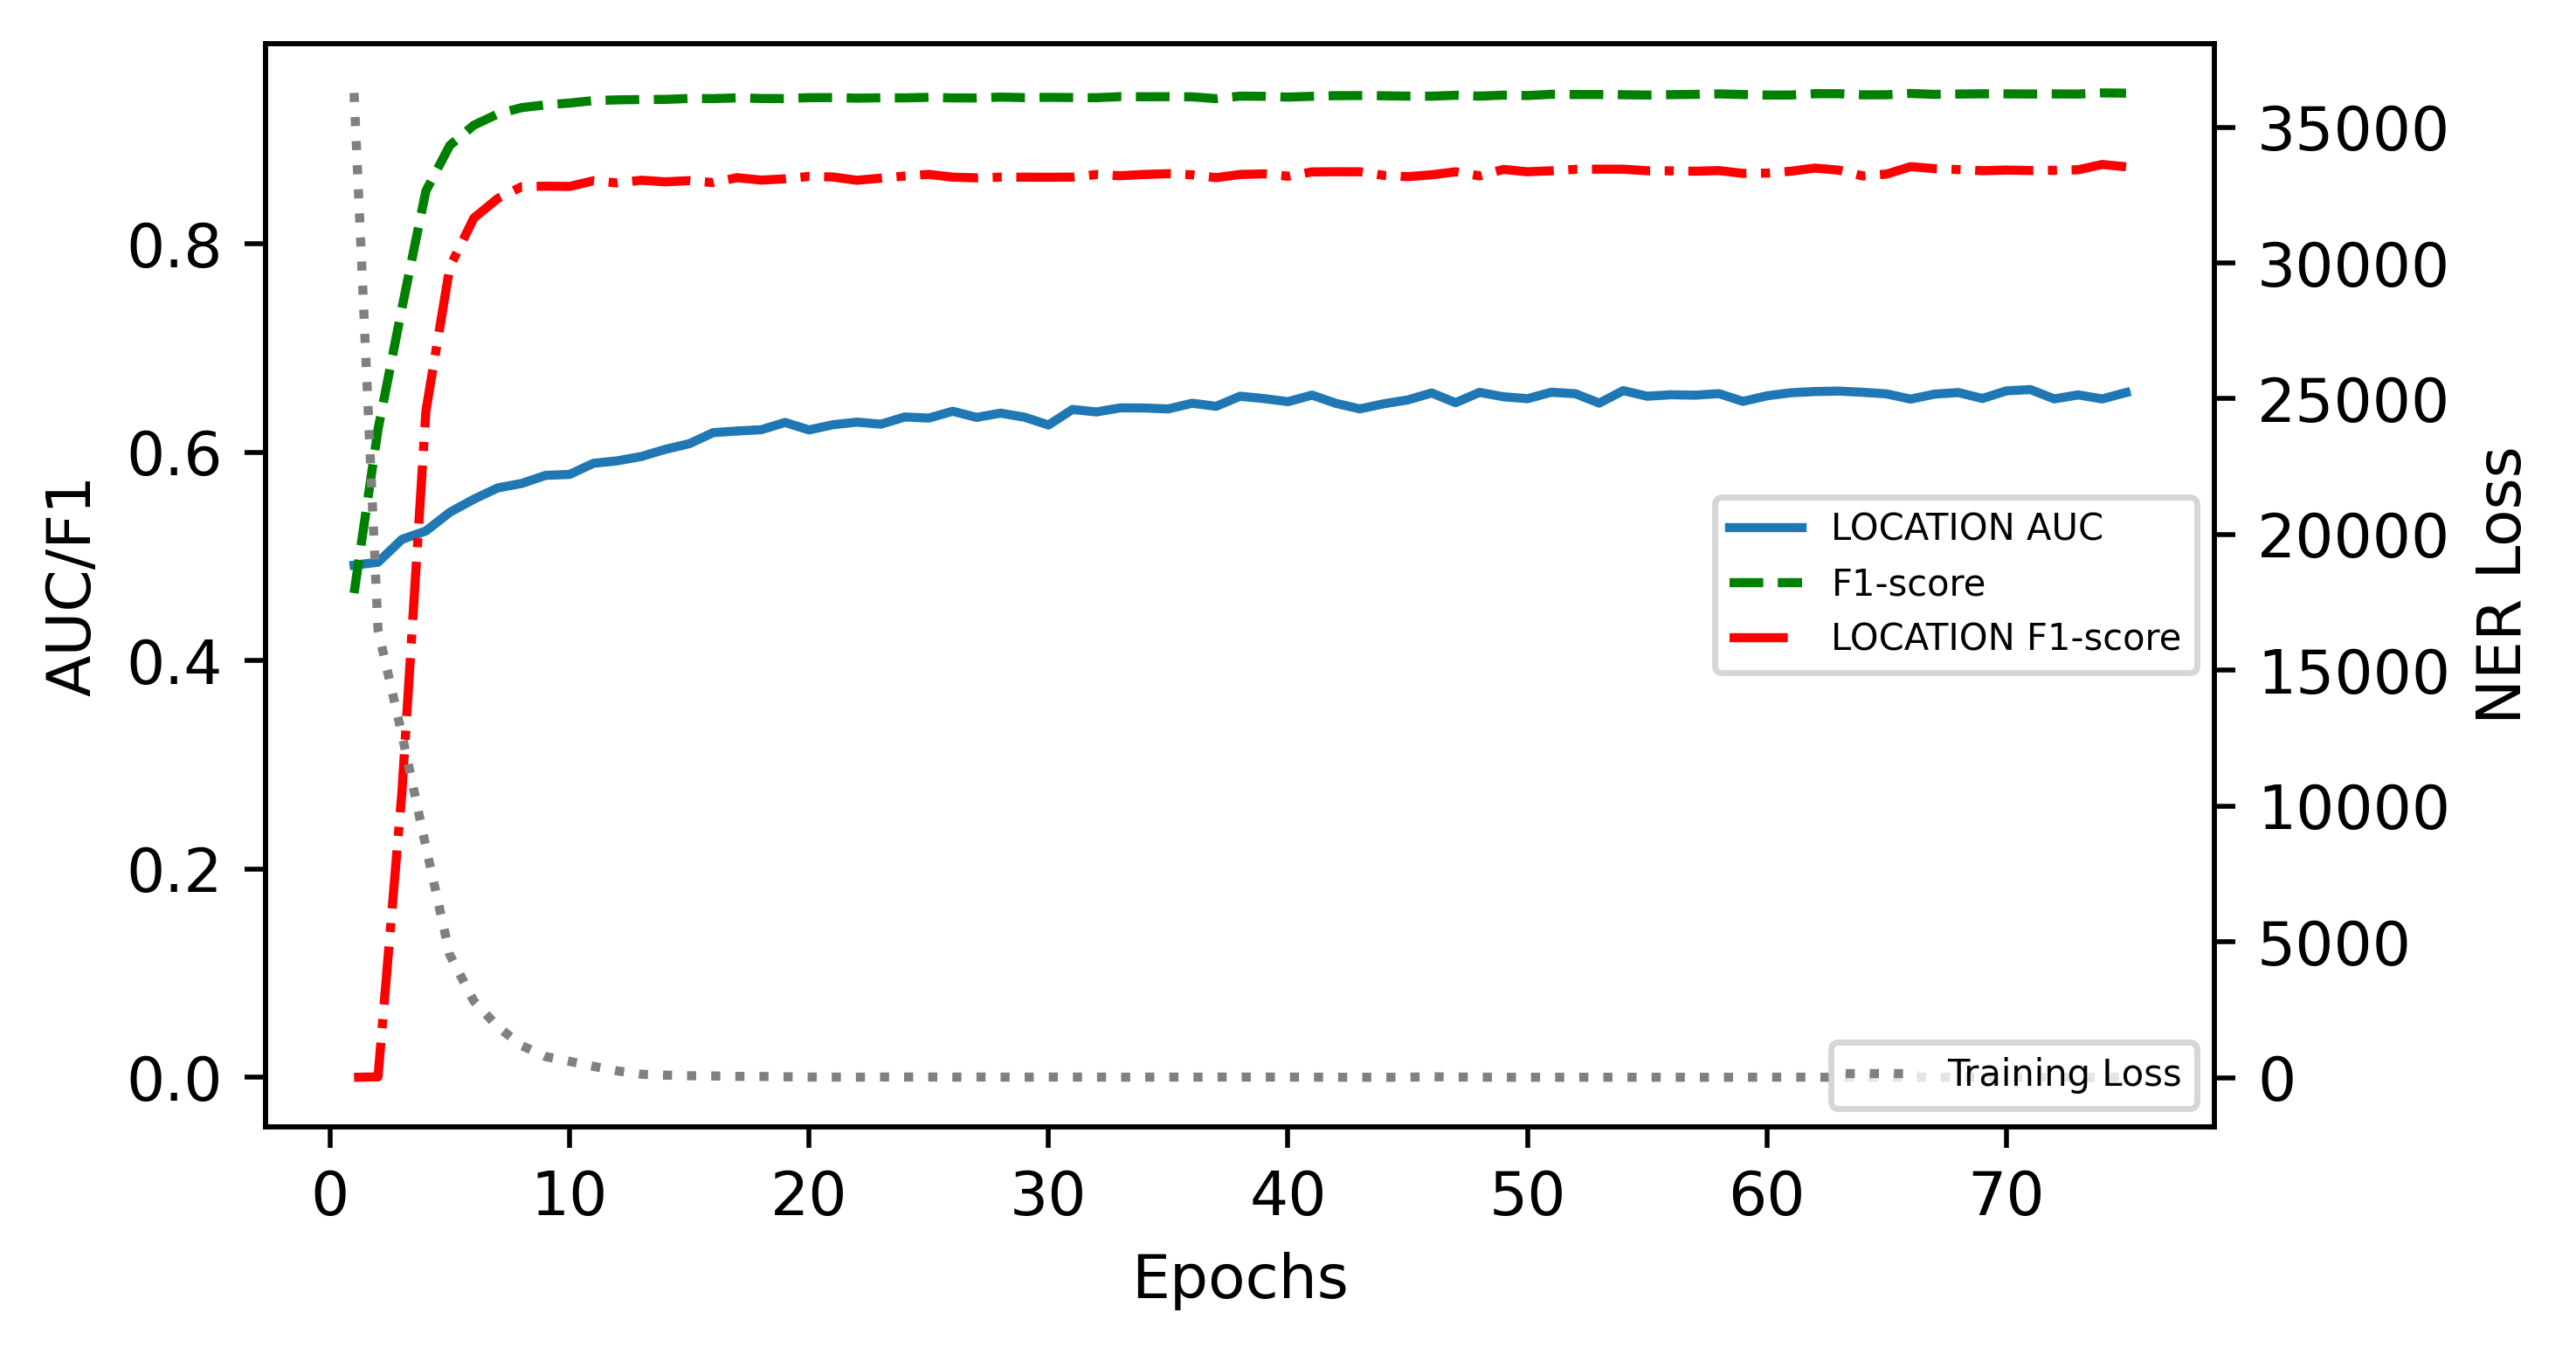

<Figure size 3000x1600 with 0 Axes>

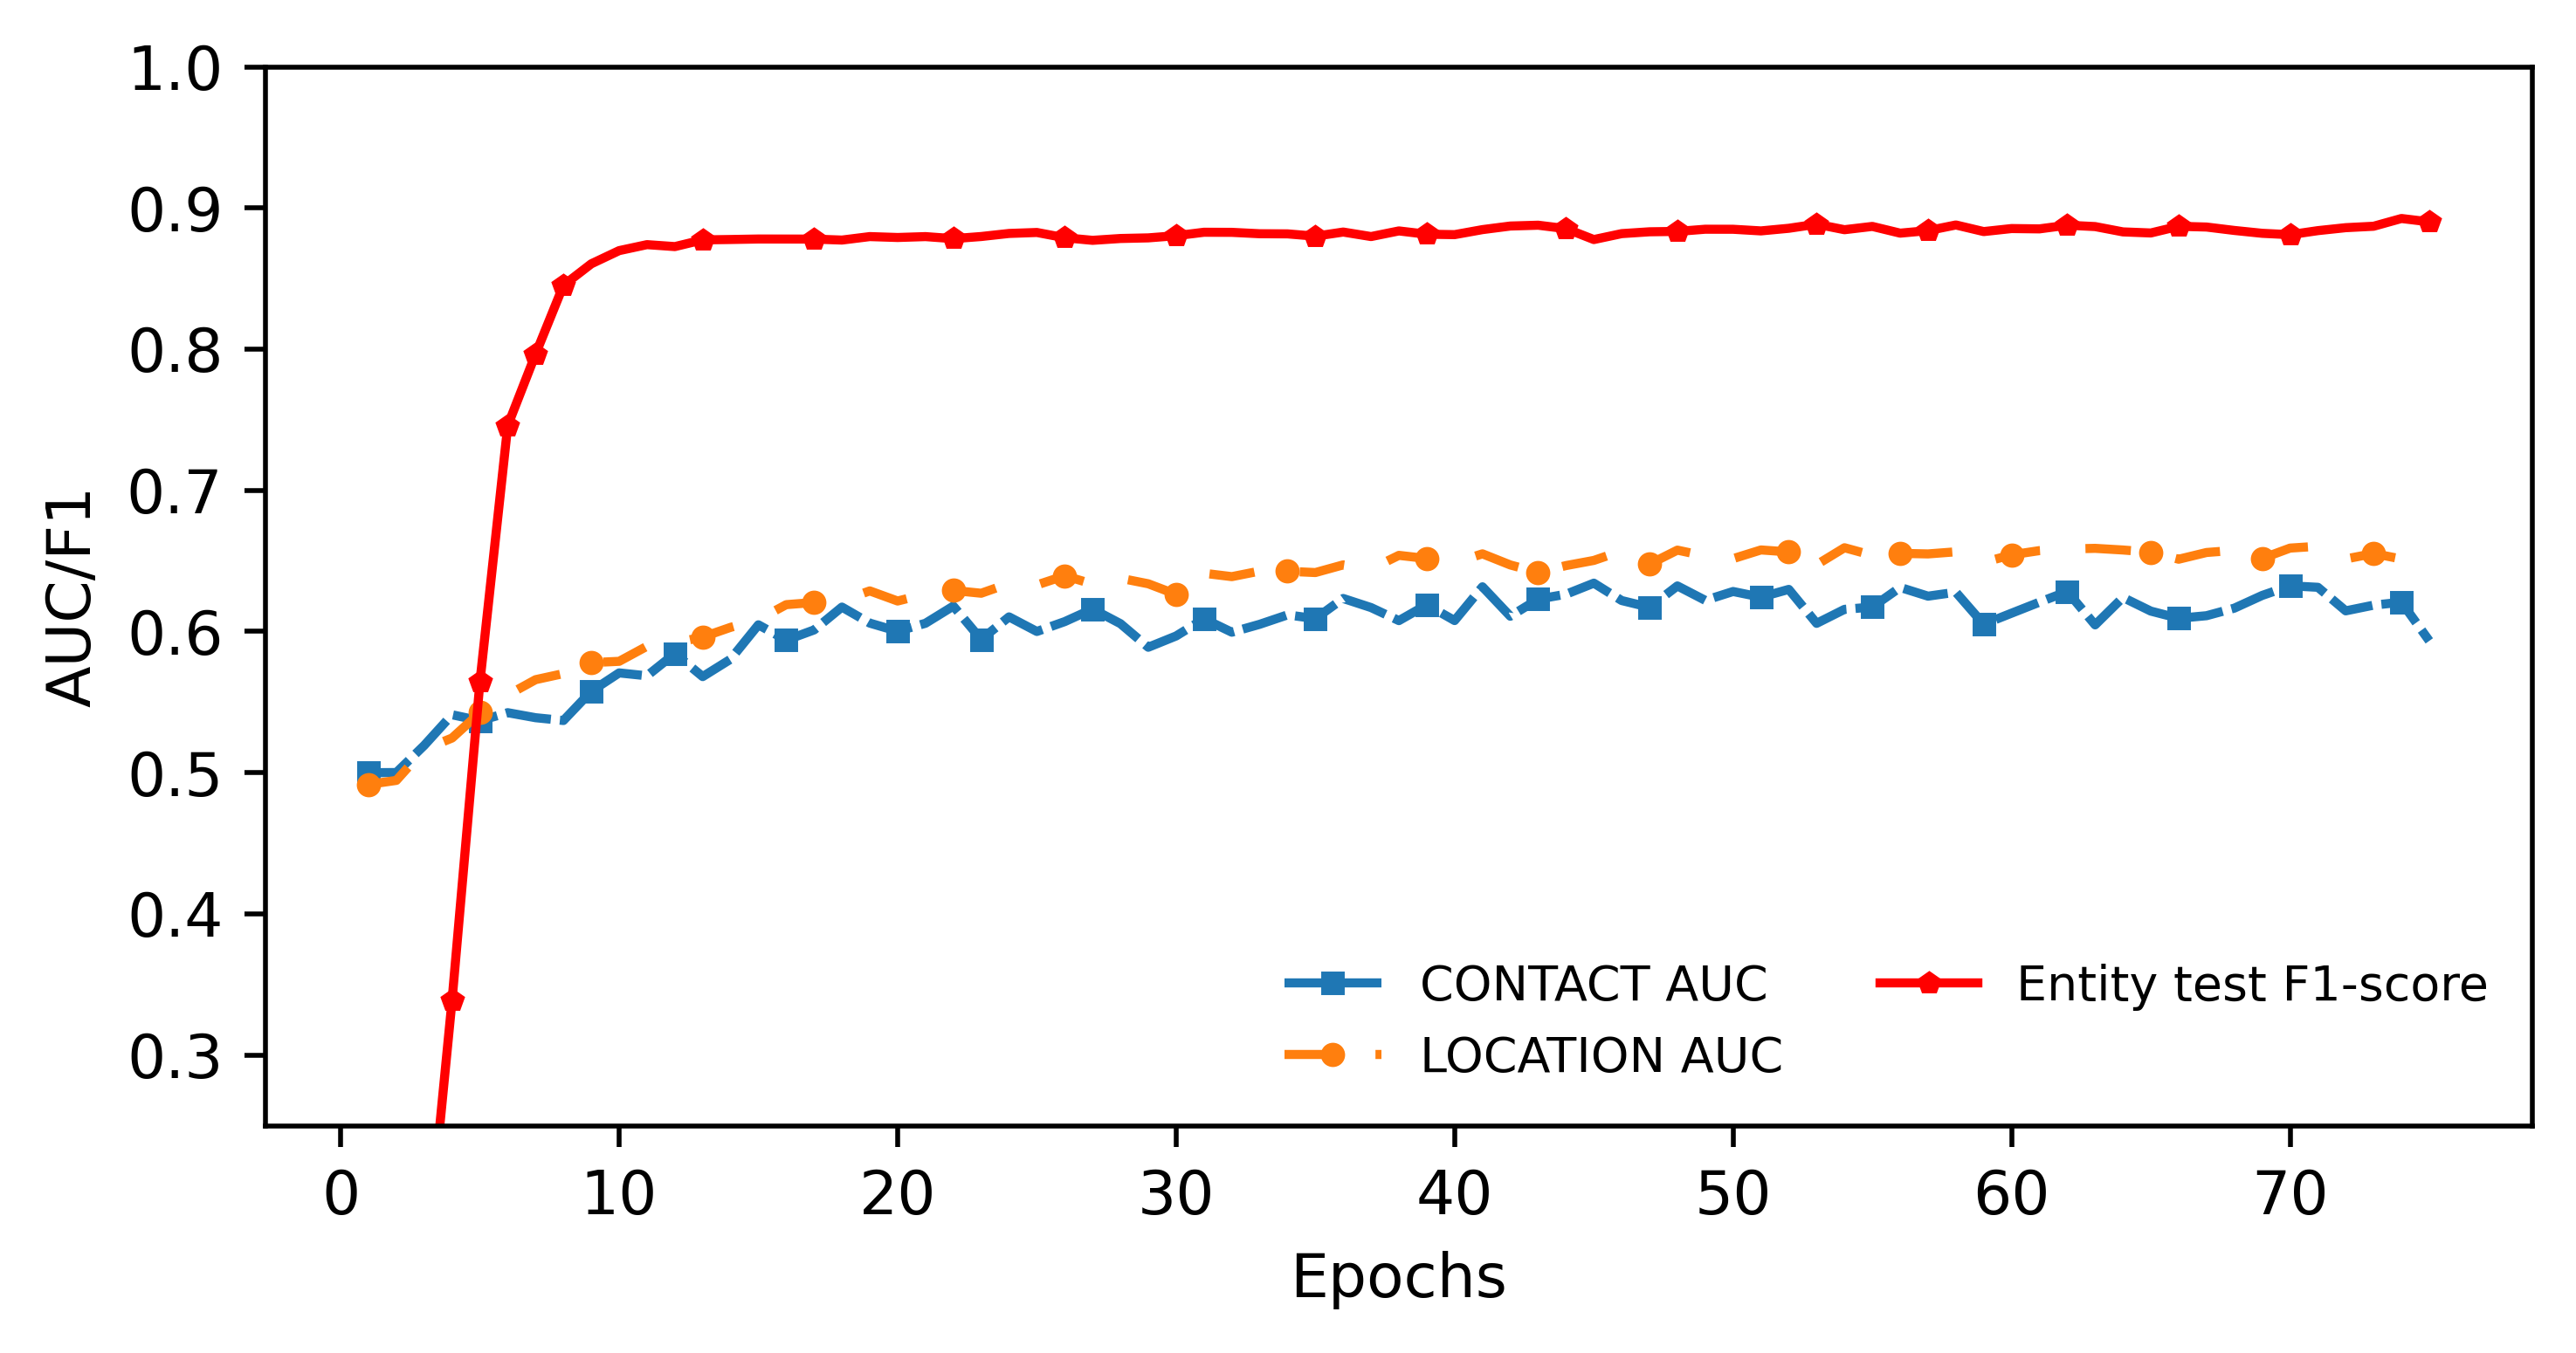

<Figure size 3000x1600 with 0 Axes>

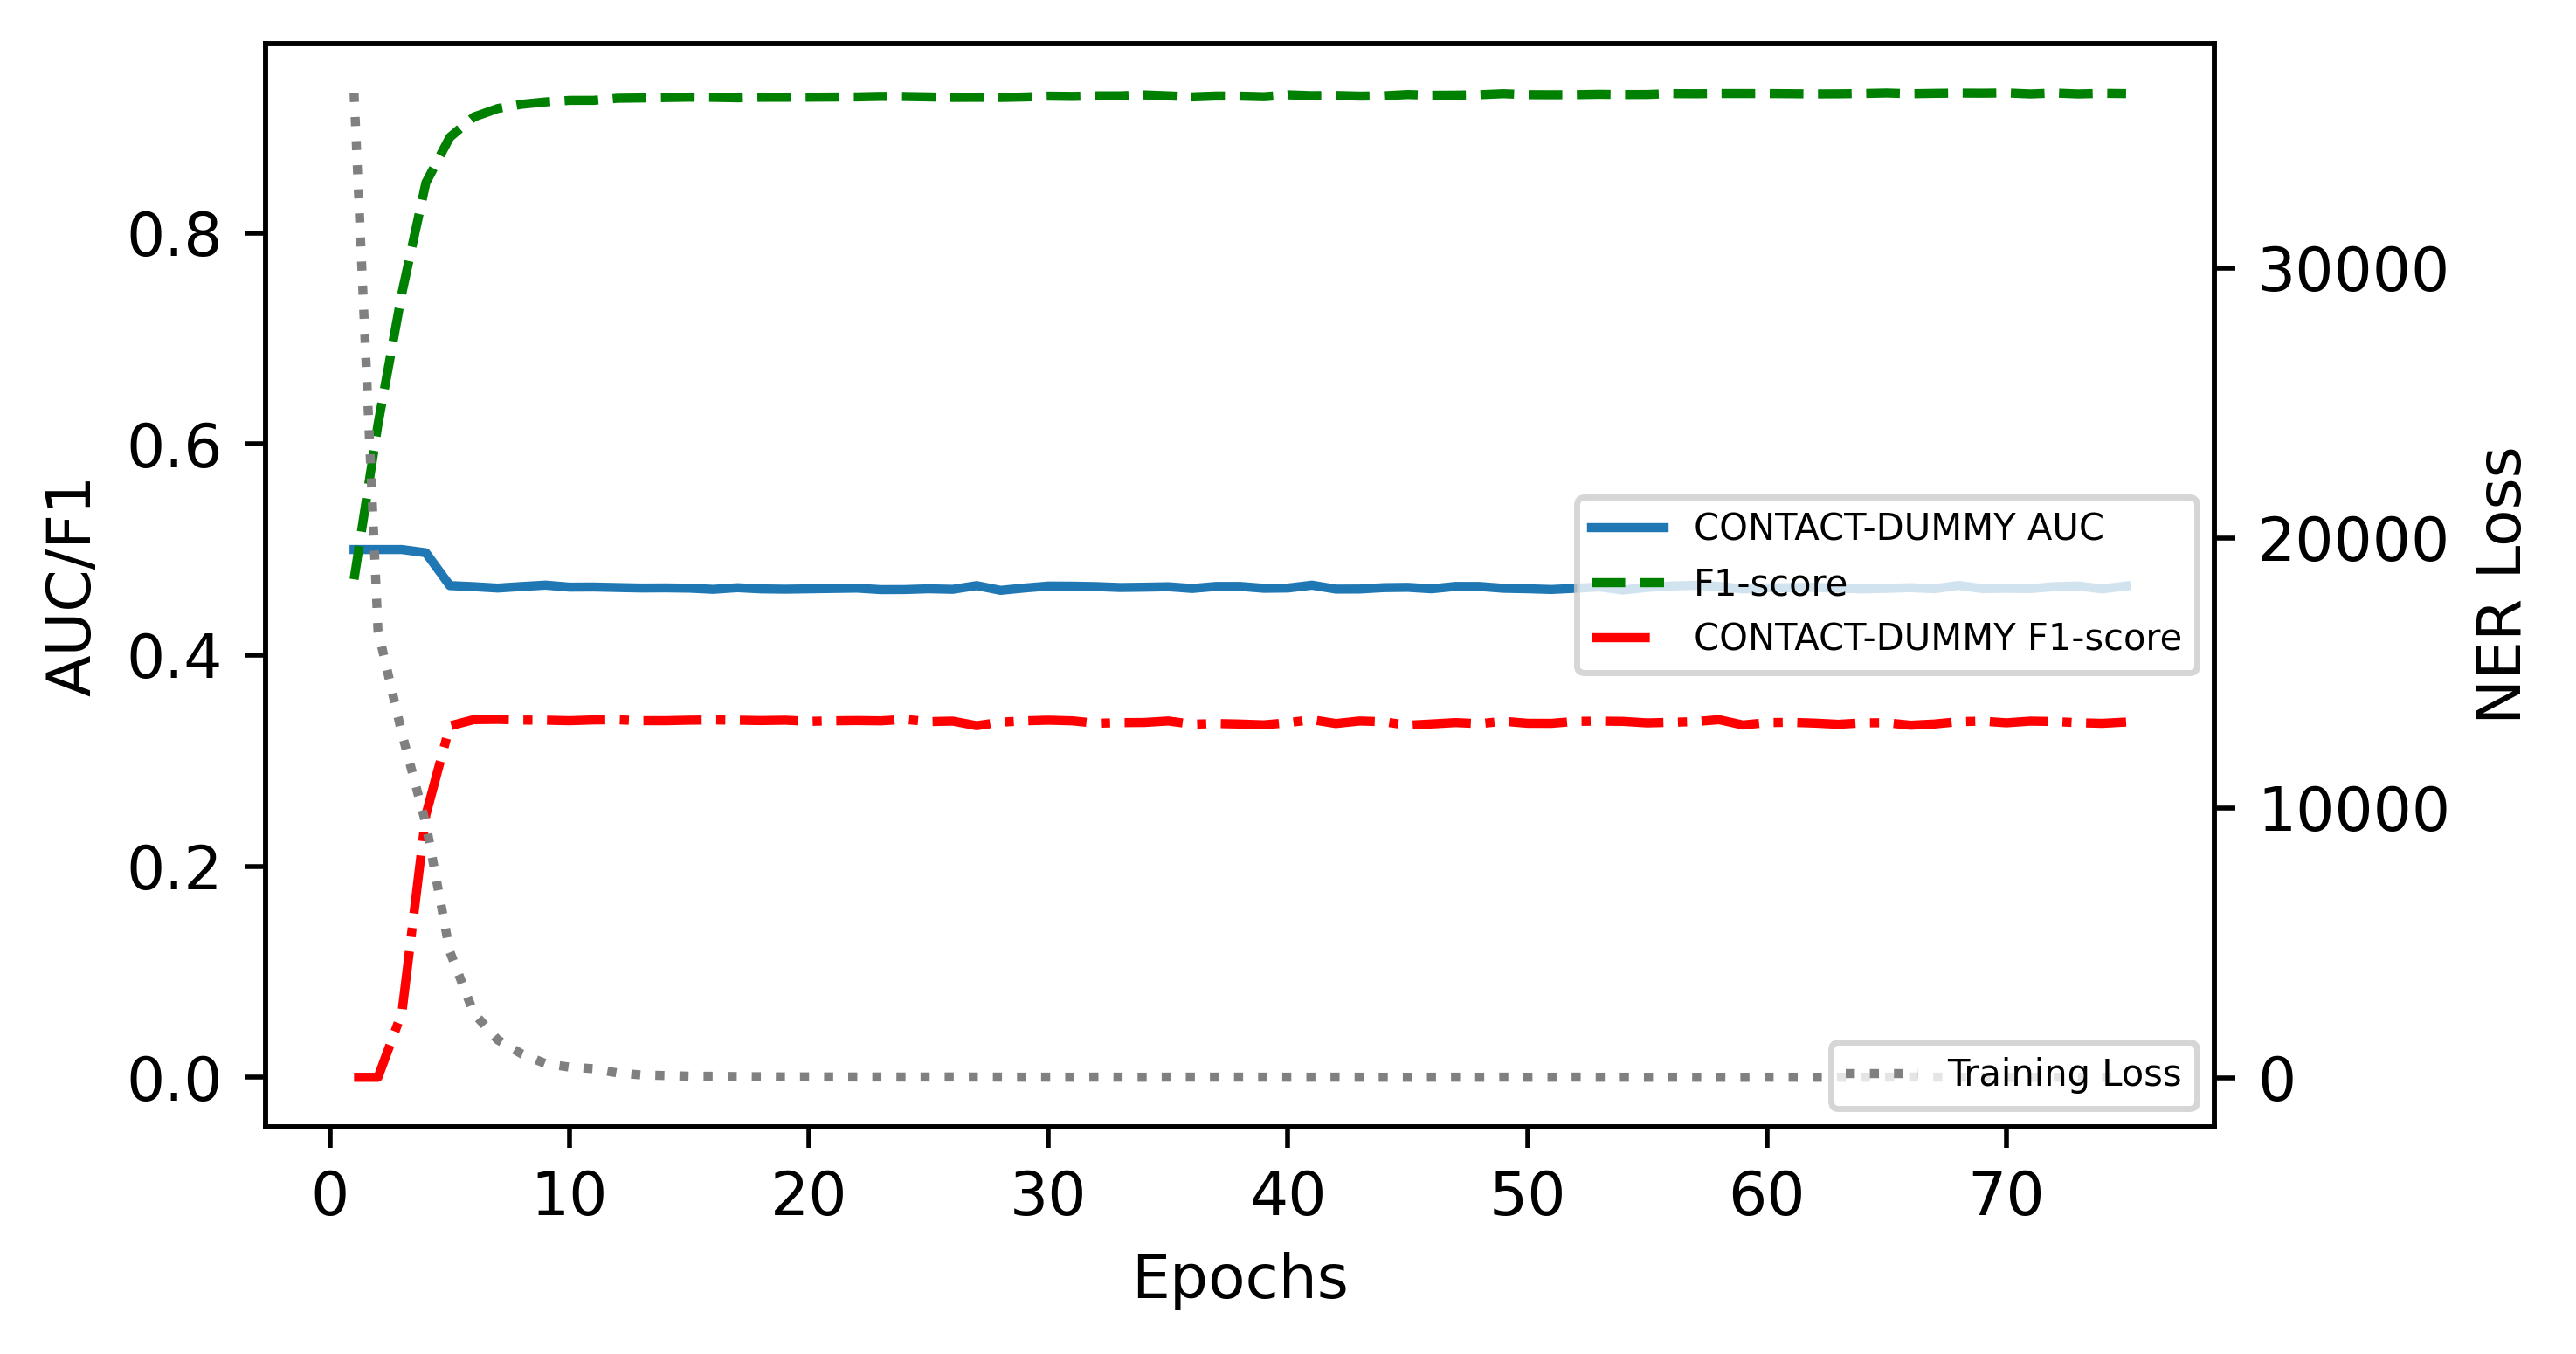

<Figure size 3000x1600 with 0 Axes>

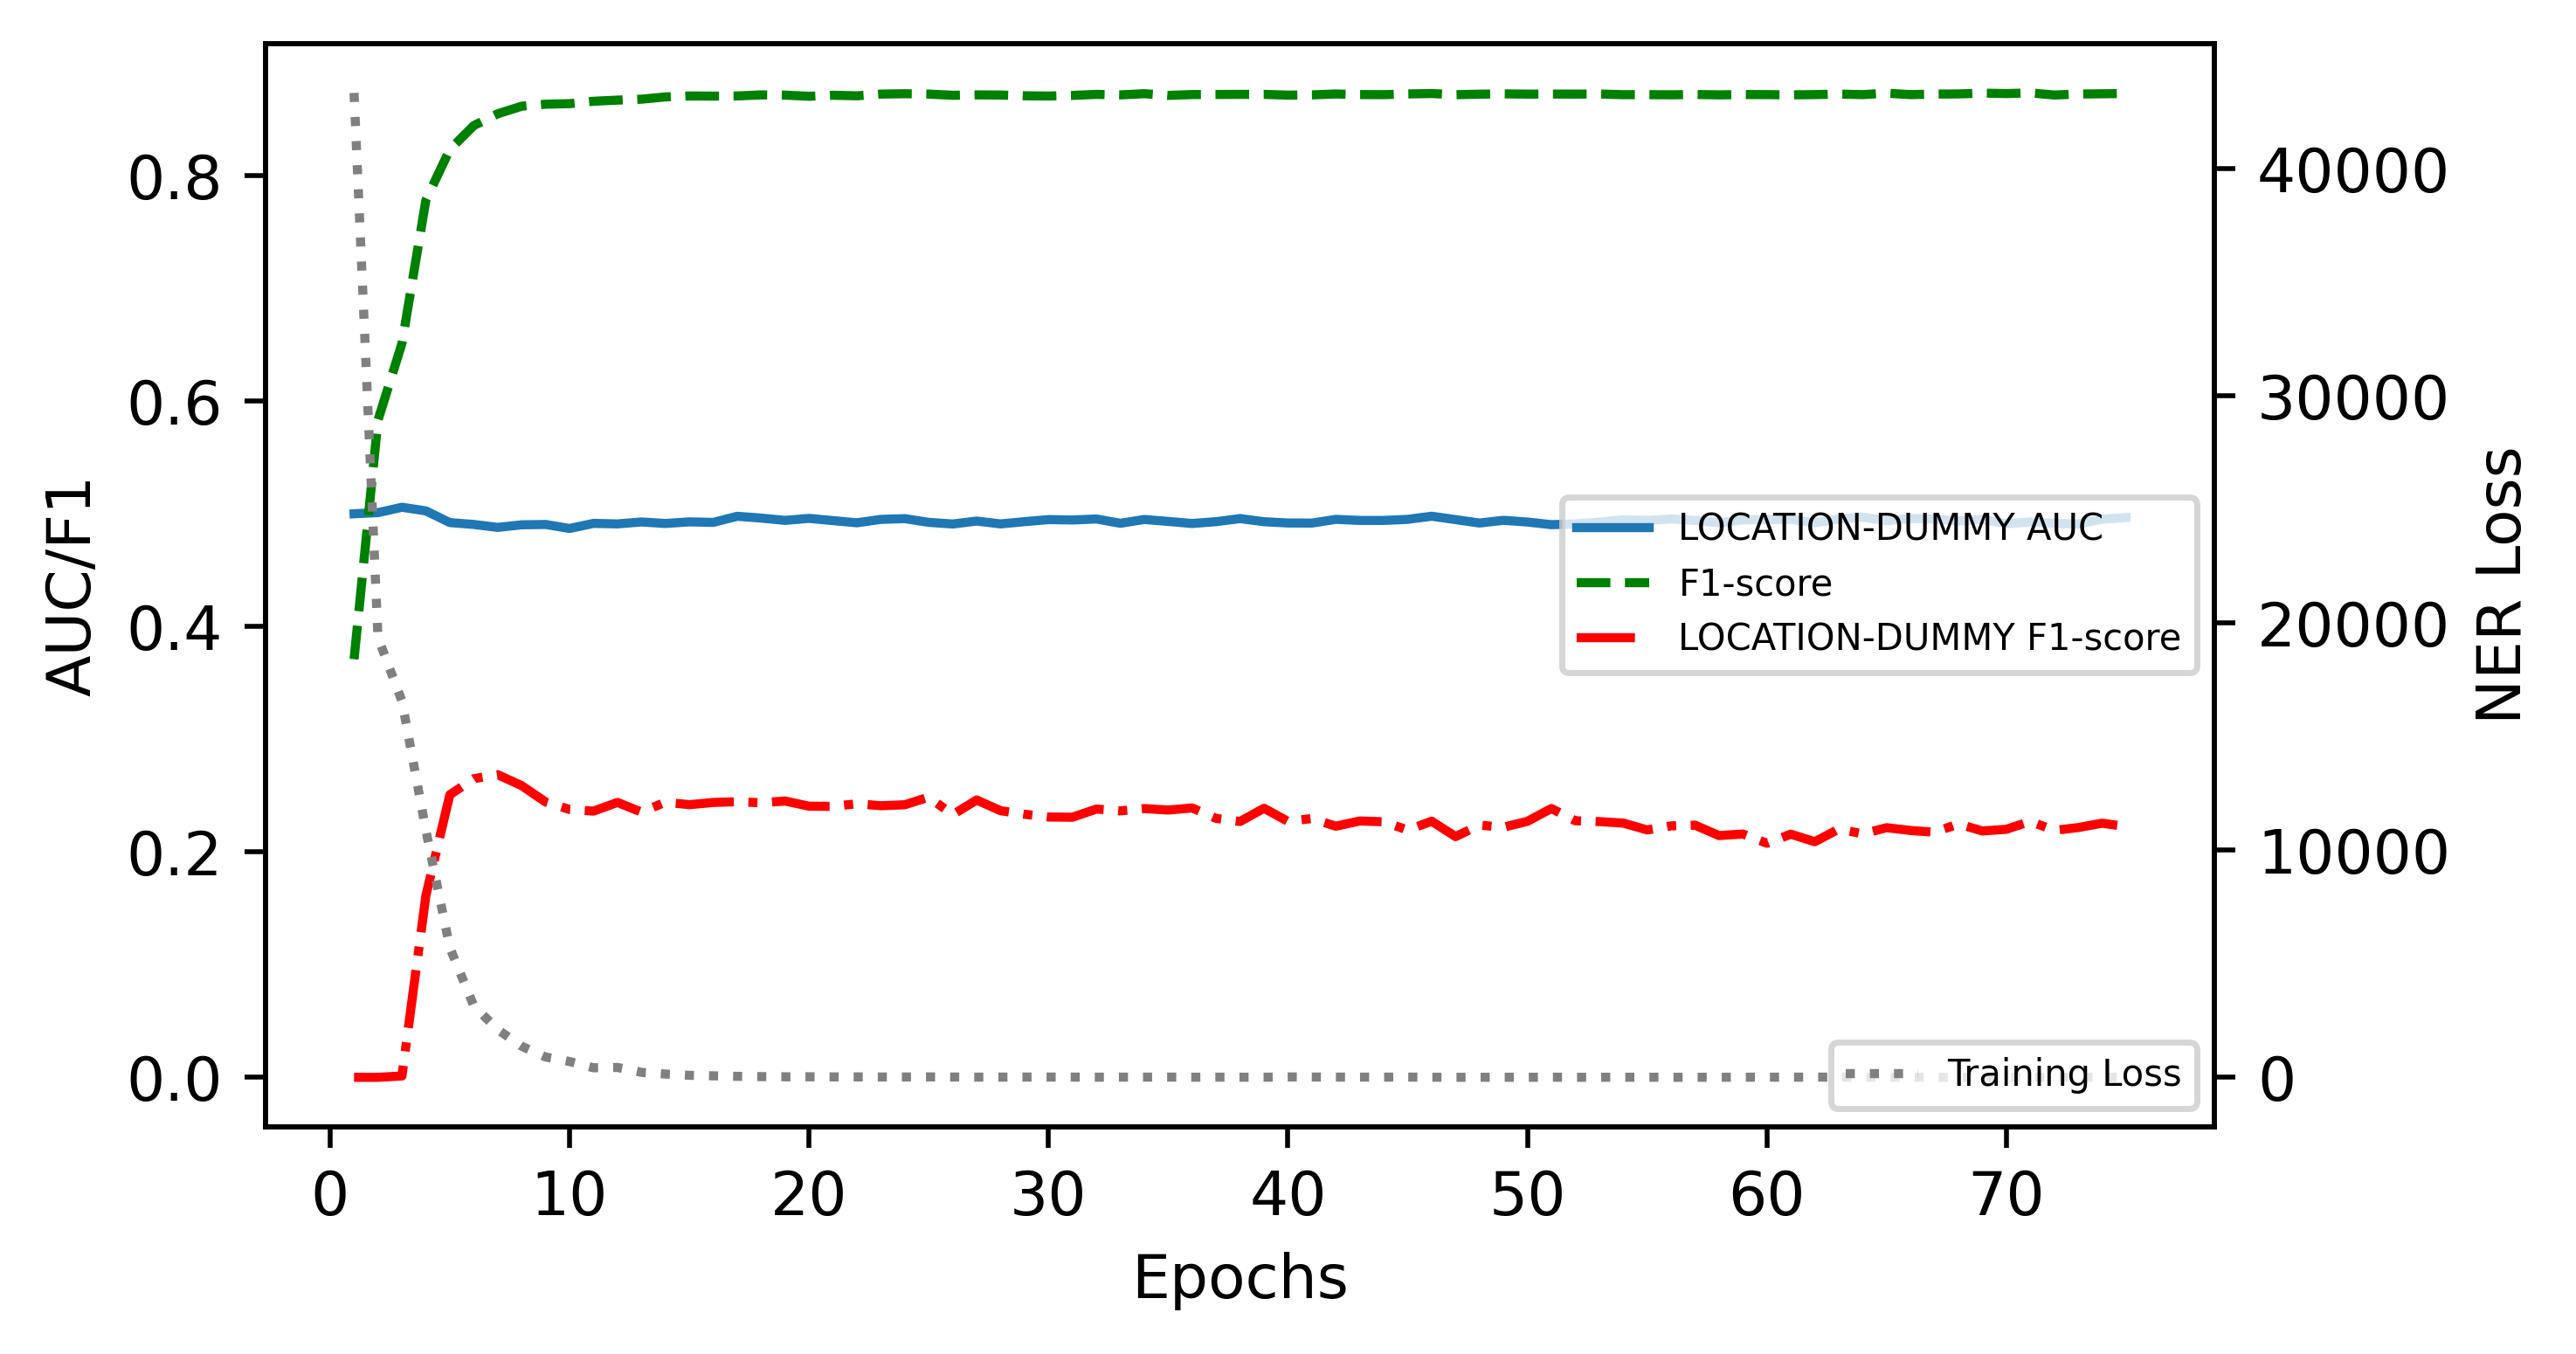

<Figure size 3000x1600 with 0 Axes>

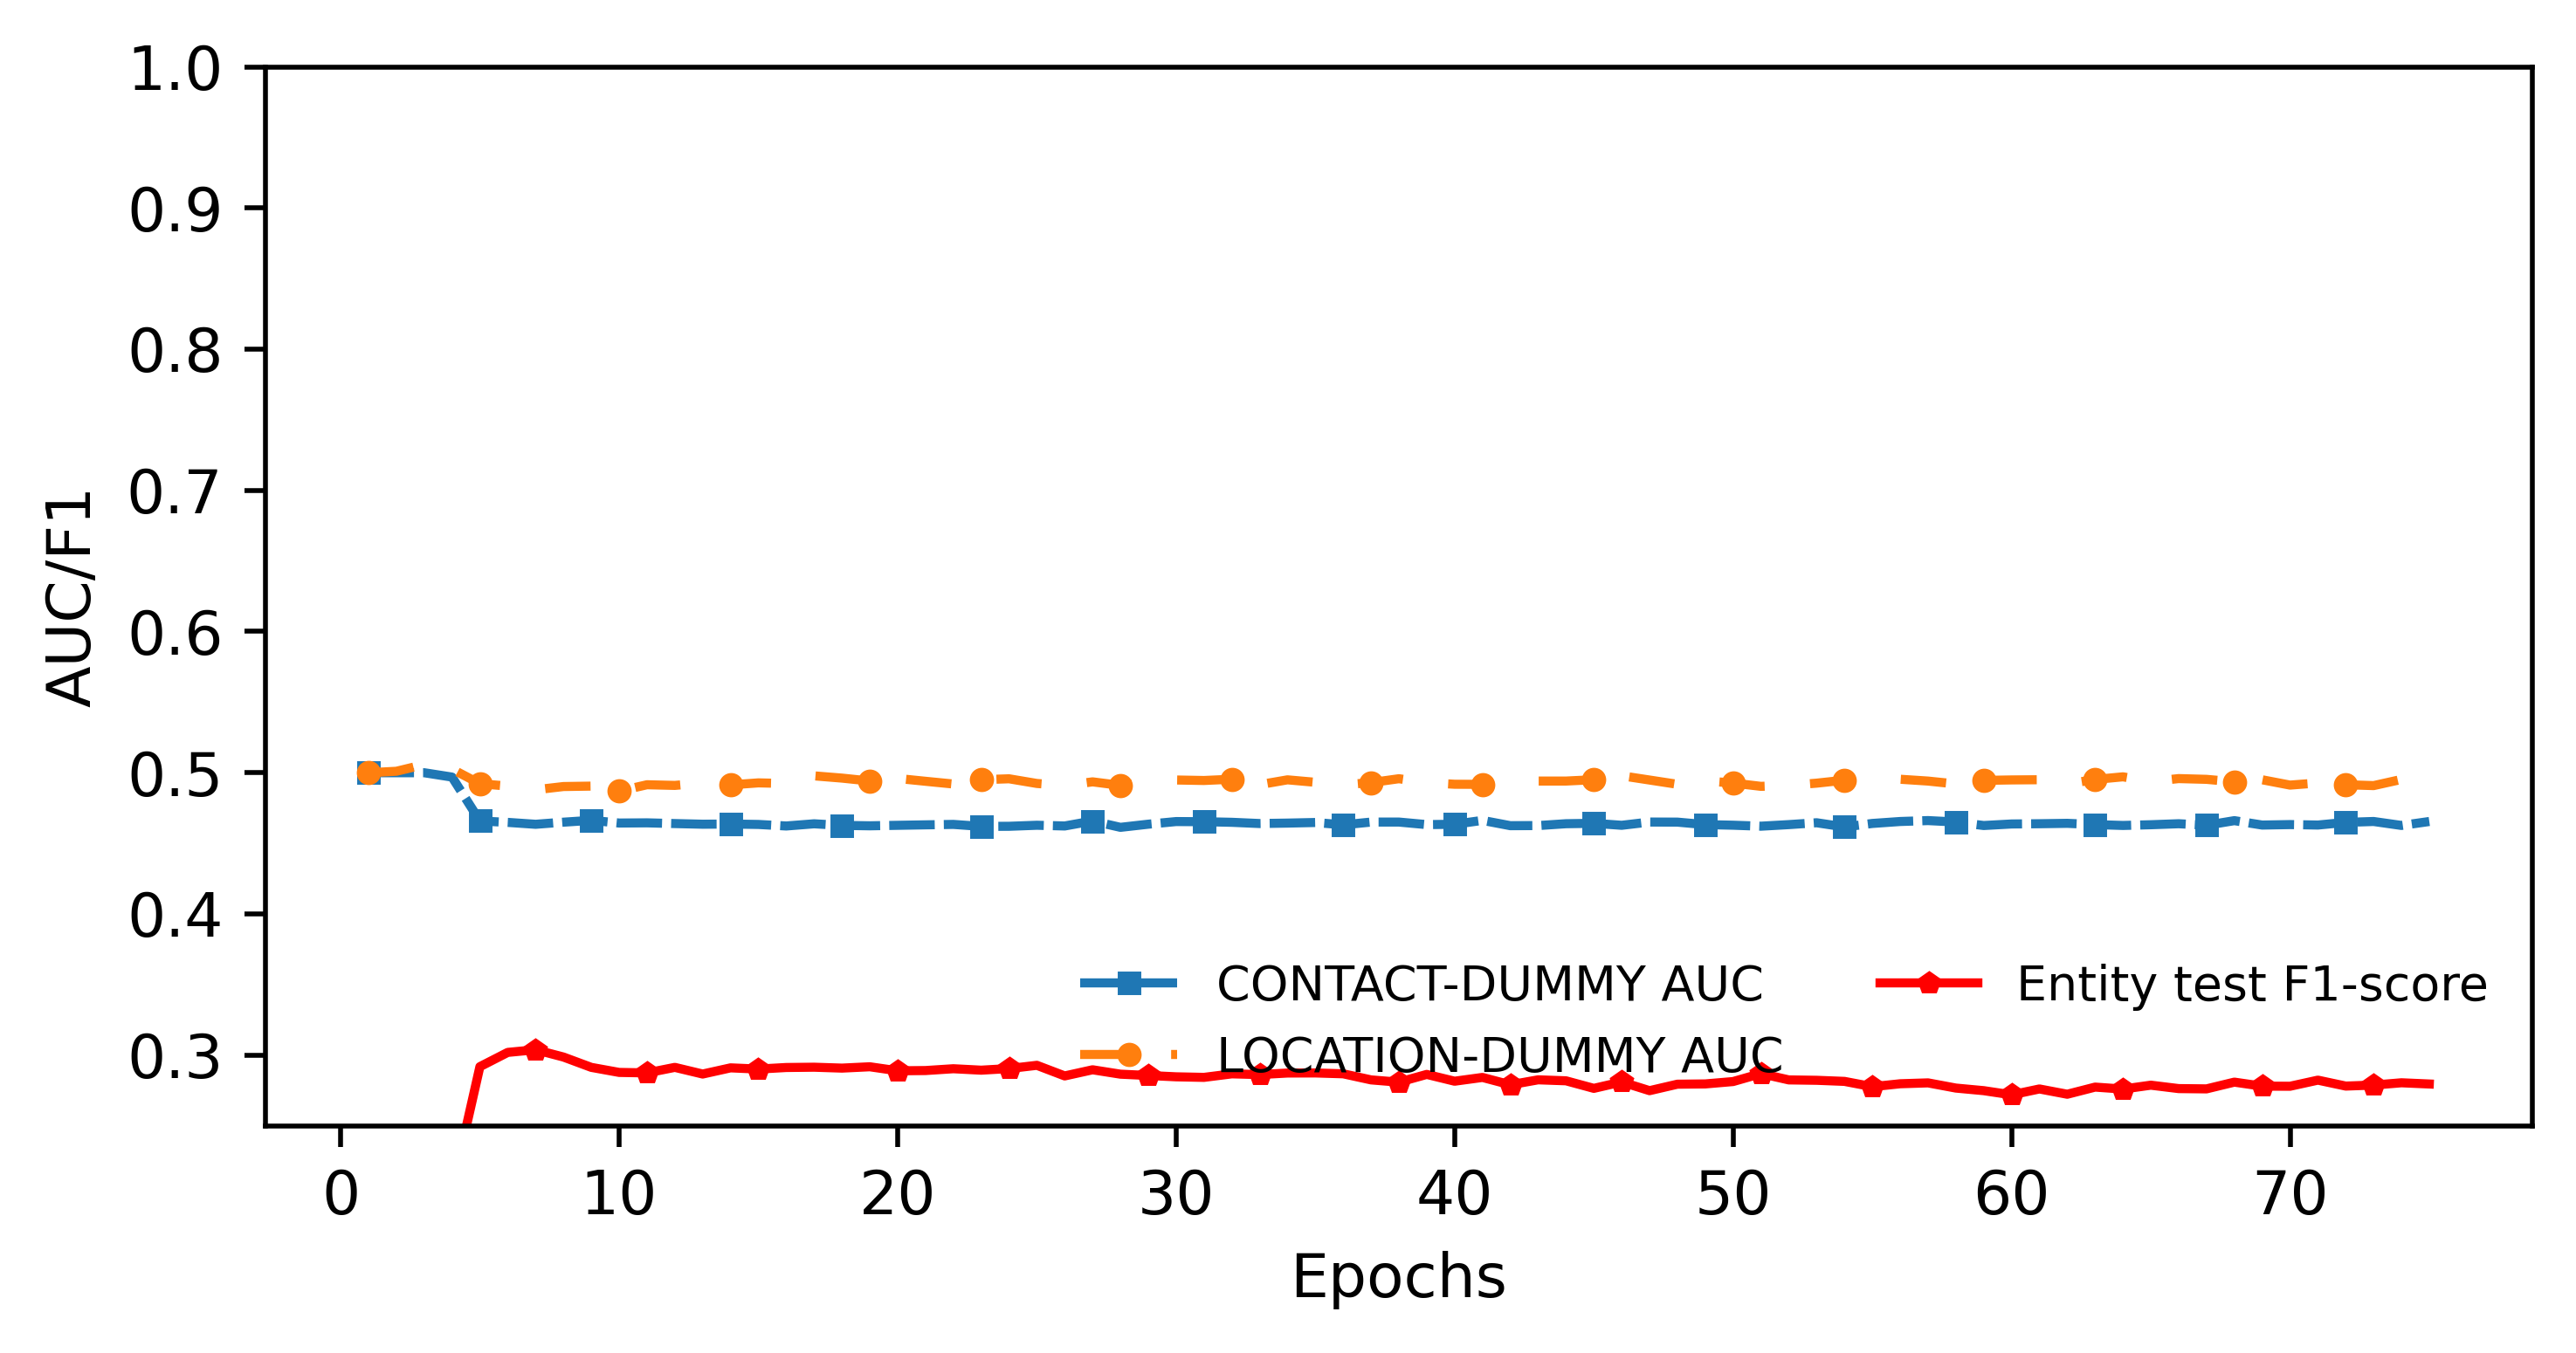

In [73]:
#results = ["Results/20210505_spacy_3.0.3_attack_MIA_epochs_75_batch_size_dataset_i2b2_n2c2_train_data_ID", "Results/20210506_spacy_3.0.3_attack_MIA_epochs_75_batch_size_dataset_i2b2_n2c2_train_data_LOCATION", "Results/20210505_spacy_3.0.3_attack_MIA_epochs_75_batch_size_dataset_i2b2_n2c2_train_data_CONTACT", "Results/20210506_spacy_3.0.3_attack_MIA_epochs_75_batch_size_dataset_i2b2_n2c2_train_data_CONTACT_size_more_than_5_CONTACT-5","Results/20210506_spacy_3.0.3_attack_MIA_epochs_75_batch_size_dataset_i2b2_n2c2_train_data_CONTACT_size_more_than_5_count_50_CONTACT-5-50", "Results/20210507_spacy_3.0.3_attack_MIA_epochs_75_batch_size_dataset_i2b2_n2c2_train_data_CONTACT_size_more_than_5_count_CONTACT-5-30", "Results/20210507_spacy_3.0.3_attack_MIA_epochs_75_batch_size_dataset_i2b2_n2c2_train_data_CONTACT_size_more_than_5_count_CONTACT-5-10", "Results/20210626_spacy_3.0.3_attack_MIA_epochs_75_batch_size_dataset_i2b2_n2c2_train_data_SECRET_size_more_than_5_count_100_SECRET-100", "Results/20210628_spacy_3.0.3_attack_MIA_epochs_75_batch_size_dataset_i2b2_n2c2_train_data_SECRET_size_more_than_5_count_50_SECRET-50"]
#results = ["Results/20210706_spacy_3.0.3_attack_MIA_epochs_75_batch_size_dataset_i2b2_n2c2_train_data_SECRET_size_more_than_5_count_30", "Results/20210706_spacy_3.0.3_attack_MIA_epochs_75_batch_size_dataset_i2b2_n2c2_train_data_SECRET_size_more_than_5_count_50", "Results/20210706_spacy_3.0.3_attack_MIA_epochs_75_batch_size_dataset_i2b2_n2c2_train_data_SECRET_size_more_than_5_count_100", "Results/20210706_spacy_3.0.3_attack_MIA_epochs_75_batch_size_dataset_i2b2_n2c2_train_data_SECRET_size_more_than_5_count_150"]
#results = ["Results/20210629_spacy_3.0.3_attack_MIA_epochs_75_batch_size_dataset_i2b2_n2c2_train_data_SECRET_size_more_than_5_count_150_SECRET-150", "Results/20210629_spacy_3.0.3_attack_MIA_epochs_75_batch_size_dataset_i2b2_n2c2_train_data_SECRET_size_more_than_5_count_100_SECRET-100", "Results/20210629_spacy_3.0.3_attack_MIA_epochs_75_batch_size_dataset_i2b2_n2c2_train_data_SECRET_size_more_than_5_count_50_SECRET-50", "Results/20210701_spacy_3.0.3_attack_MIA_epochs_75_batch_size_dataset_i2b2_n2c2_train_data_SECRET_size_more_than_5_count_30_SECRET-30"]
#res_folder = "Results/20210505_spacy_3.0.3_attack_MIA_epochs_75_batch_size_dataset_i2b2_n2c2_train_data_CONTACT"
#results = ["Results/20210707_spacy_3.0.3_attack_MIA_epochs_75_batch_size_dataset_i2b2_n2c2_train_data_RANDOM_PREFIX_SECRET_size_more_than_5_count_30", "Results/20210707_spacy_3.0.3_attack_MIA_epochs_75_batch_size_dataset_i2b2_n2c2_train_data_RANDOM_PREFIX_SECRET_size_more_than_5_count_50", "Results/20210707_spacy_3.0.3_attack_MIA_epochs_75_batch_size_dataset_i2b2_n2c2_train_data_RANDOM_PREFIX_SECRET_size_more_than_5_count_100", "Results/20210707_spacy_3.0.3_attack_MIA_epochs_75_batch_size_dataset_i2b2_n2c2_train_data_RANDOM_PREFIX_SECRET_size_more_than_5_count_150"]

# results = ["Results/20210708_spacy_3.0.3_attack_MIA_epochs_75_batch_size_dataset_i2b2_n2c2_train_data_RANDOM_TRAINING_SAME_TEST_SECRET_size_more_than_5_count_SECRET-30", "Results/20210708_spacy_3.0.3_attack_MIA_epochs_75_batch_size_dataset_i2b2_n2c2_train_data_RANDOM_TRAINING_SAME_TEST_SECRET_size_more_than_5_count_SECRET-50", "Results/20210708_spacy_3.0.3_attack_MIA_epochs_75_batch_size_dataset_i2b2_n2c2_train_data_RANDOM_TRAINING_SAME_TEST_SECRET_size_more_than_5_count_SECRET-100", "Results/20210708_spacy_3.0.3_attack_MIA_epochs_75_batch_size_dataset_i2b2_n2c2_train_data_RANDOM_TRAINING_SAME_TEST_SECRET_size_more_than_5_count_SECRET-150"]
# experiment = 'RANDOM_TRAIN_SAME_TEST_SECRET-30-50-100-150'

# results = ["Results/20210708_spacy_3.0.3_attack_MIA_epochs_75_batch_size_dataset_i2b2_n2c2_train_data_SECRET_size_more_than_5_count_SECRET-30", "Results/20210708_spacy_3.0.3_attack_MIA_epochs_75_batch_size_dataset_i2b2_n2c2_train_data_SECRET_size_more_than_5_count_SECRET-50", "Results/20210708_spacy_3.0.3_attack_MIA_epochs_75_batch_size_dataset_i2b2_n2c2_train_data_SECRET_size_more_than_5_count_SECRET-100", "Results/20210708_spacy_3.0.3_attack_MIA_epochs_75_batch_size_dataset_i2b2_n2c2_train_data_SECRET_size_more_than_5_count_SECRET-150"]
# experiment = 'SECRET-30-50-100-150'

# results = ["Results/Figure_7/20210713_spacy_3.0.3_attack_MIA_epochs_75_batch_size_dataset_i2b2_n2c2_train_data_CONTACT_size_more_than_0_count_None_CONTACT", "Results/Figure_7/20210713_spacy_3.0.3_attack_MIA_epochs_75_batch_size_dataset_i2b2_n2c2_train_data_CONTACT_size_more_than_5_count_None_CONTACT-5", "Results/Figure_7/20210713_spacy_3.0.3_attack_MIA_epochs_75_batch_size_dataset_i2b2_n2c2_train_data_CONTACT_size_more_than_5_count_10_CONTACT-5-10", "Results/Figure_7/20210713_spacy_3.0.3_attack_MIA_epochs_75_batch_size_dataset_i2b2_n2c2_train_data_CONTACT_size_more_than_5_count_30_CONTACT-5-30", "Results/Figure_7/20210713_spacy_3.0.3_attack_MIA_epochs_75_batch_size_dataset_i2b2_n2c2_train_data_CONTACT_size_more_than_5_count_50_CONTACT-5-50", "Results/Figure_7/20210713_spacy_3.0.3_attack_MIA_epochs_75_batch_size_dataset_i2b2_n2c2_train_data_ID_size_more_than_0_count_None_ID", "Results/Figure_7/20210713_spacy_3.0.3_attack_MIA_epochs_75_batch_size_dataset_i2b2_n2c2_train_data_LOCATION_size_more_than_0_count_None_LOCATION"]
# experiment = 'CONTACT-ID-LOCATION-SECRET-30-50-100-150'

# results = ["../Results/MIA_Results/20220603_spacy_3.1.2_attack_MIA_epochs_75_batch_size_dataset_i2b2_n2c2_train_data_CONTACT_size_more_than_0_count_None_replace_dummy_True_CONTACT", "../Results/MIA_Results/20220603_spacy_3.1.2_attack_MIA_epochs_75_batch_size_dataset_i2b2_n2c2_train_data_LOCATION_size_more_than_0_count_None_replace_dummy_True_LOCATION"]
# experiment = 'CONTACT-LOCATION-DUMMY_TRAINING_MEMBERSET_DUMMY'

# results = ["../Results/MIA_Results/20220604_spacy_3.1.2_attack_MIA_epochs_75_batch_size_dataset_i2b2_n2c2_train_data_CONTACT_size_more_than_0_count_None_replace_dummy_True_CONTACT-DUMMY", "../Results/MIA_Results/20220604_spacy_3.1.2_attack_MIA_epochs_75_batch_size_dataset_i2b2_n2c2_train_data_LOCATION_size_more_than_0_count_None_replace_dummy_True_LOCATION-DUMMY"]
results_list = [{"exp_name":"CONTACT-LOCATION-DUMMY_TRAINING_MEMBERSET_ORIGNIAL_DUMMY", "result":["../Results/MIA_Results/20210713_spacy_3.0.3_attack_MIA_epochs_75_batch_size_dataset_i2b2_n2c2_train_data_CONTACT_size_more_than_0_count_None_CONTACT", "../Results/MIA_Results/20210713_spacy_3.0.3_attack_MIA_epochs_75_batch_size_dataset_i2b2_n2c2_train_data_LOCATION_size_more_than_0_count_None_LOCATION"]}, {"exp_name":"CONTACT-LOCATION-DUMMY_TRAINING_MEMBERSET_ORIGNIAL_DUMMY", "result":["../Results/MIA_Results/20220604_spacy_3.1.2_attack_MIA_epochs_75_batch_size_dataset_i2b2_n2c2_train_data_CONTACT_size_more_than_0_count_None_replace_dummy_True_CONTACT-DUMMY", "../Results/MIA_Results/20220604_spacy_3.1.2_attack_MIA_epochs_75_batch_size_dataset_i2b2_n2c2_train_data_LOCATION_size_more_than_0_count_None_replace_dummy_True_LOCATION-DUMMY"]}]


plt_list = []
for result_dict in results_list:
    results = result_dict["result"]
    experiment = result_dict["exp_name"]
    aucs_per_epoch = []

    plot_folder = "../Results/MIA_Results_PLOTS/{}/".format(experiment)
    mkdir_p(plot_folder)

    total_avg_loss = []
    total_epoch_scores = []
    total_secret_f1 = []

    for res_folder in results:
        g = unpack_data(res_folder)
        epochs = g[0][0]
        _ = g[0][1]
        batch_size = g[0][2]
        epoch_losses = g[0][3]
        sub_runs = len(g[0][3])
        member_scores = g[0][4]
        non_member_scores = g[0][5]
        member_scores_per_epoch = g[0][6]
        non_member_scores_per_epoch = g[0][7]
        epoch_scores = g[0][8]
        scorer_scores = g[0][9]
        entity = res_folder.split('_')[-1]
        
        score_ent = entity.split('-')[0]
        
        auc_per_epoch = get_auc_per_epoch(member_scores_per_epoch, non_member_scores_per_epoch)
        aucs_per_epoch.append((auc_per_epoch, entity))
        
        avg_losses = []

        for subrun in range(len(epoch_losses)):
            epochs = [t[0] for t in epoch_losses[subrun]]
            losses = [t[1] for t in epoch_losses[subrun]]
            avg_losses.append(losses)
        avg_losses = [np.mean(np.array(t)) for t in list(zip(*avg_losses))]
        total_avg_loss.append(avg_losses)

        avg_epoch_scores = []
        if len(g[0])>7:

            for subrun in range(len(epoch_scores)):
                epochs = [t[0] for t in epoch_scores[subrun]]
                f1 = [t[1][2] for t in epoch_scores[subrun]]
                avg_epoch_scores.append(f1)
            avg_epoch_scores = [np.mean(np.array(t)) for t in list(zip(*avg_epoch_scores))]
            total_epoch_scores.append(avg_epoch_scores)
            
        avg_secret_f1 = []
        if len(g[0])>8:

            for subrun in range(len(scorer_scores)):
                epochs = [t[0] for t in scorer_scores[subrun]]
                secret_f1 = [t[1]['ents_per_type'][score_ent]['f'] for t in scorer_scores[subrun]]
                avg_secret_f1.append(secret_f1)
            avg_secret_f1 = [np.mean(np.array(t)) for t in list(zip(*avg_secret_f1))]
            total_secret_f1.append(avg_secret_f1)
        
        plot_auc_line((auc_per_epoch, entity), experiment+entity+".pdf", plot_folder, avg_losses, avg_secret_f1, avg_epoch_scores, entity)
        #plot_loss_line(epochs, avg_losses)

        
    total_avg_loss = [np.mean(np.array(t)) for t in list(zip(*total_avg_loss))]

    total_epoch_scores = [np.mean(np.array(t)) for t in list(zip(*total_epoch_scores))]

    total_secret_f1 = [np.mean(np.array(t)) for t in list(zip(*total_secret_f1))]

    plot_name = "AUC_{}_i2b2_n2c2_dataset.pdf".format(experiment)
    plts = plot_multiple_auc_lines(aucs_per_epoch, plot_name, plot_folder, total_avg_loss, total_secret_f1, total_epoch_scores, entity)
    plt_list.append(plts)

In [74]:
plt_list

[[['CONTACT', [<matplotlib.lines.Line2D at 0x7f9e52f779e8>]],
  ['LOCATION', [<matplotlib.lines.Line2D at 0x7f9e52f779b0>]],
  ['Entity test F1-score', [<matplotlib.lines.Line2D at 0x7f9e52f772b0>]]],
 [['CONTACT-DUMMY', [<matplotlib.lines.Line2D at 0x7f9e1de67908>]],
  ['LOCATION-DUMMY', [<matplotlib.lines.Line2D at 0x7f9e1de67940>]],
  ['Entity test F1-score - DUMMY',

['CONTACT', [<matplotlib.lines.Line2D object at 0x7f9e52f779e8>]]
['LOCATION', [<matplotlib.lines.Line2D object at 0x7f9e52f779b0>]]
['Entity test F1-score', [<matplotlib.lines.Line2D object at 0x7f9e52f772b0>]]
['CONTACT-DUMMY', [<matplotlib.lines.Line2D object at 0x7f9e1de67908>]]
['LOCATION-DUMMY', [<matplotlib.lines.Line2D object at 0x7f9e1de67940>]]
['Entity test F1-score - DUMMY', [<matplotlib.lines.Line2D object at 0x7f9e1de678d0>]]
[<matplotlib.lines.Line2D object at 0x7f9e51f067f0>, <matplotlib.lines.Line2D object at 0x7f9e51f06cc0>, <matplotlib.lines.Line2D object at 0x7f9e517c08d0>, <matplotlib.lines.Line2D object at 0x7f9e5178a128>, <matplotlib.lines.Line2D object at 0x7f9e62554be0>, <matplotlib.lines.Line2D object at 0x7f9e625542b0>]


<Figure size 3000x1600 with 0 Axes>

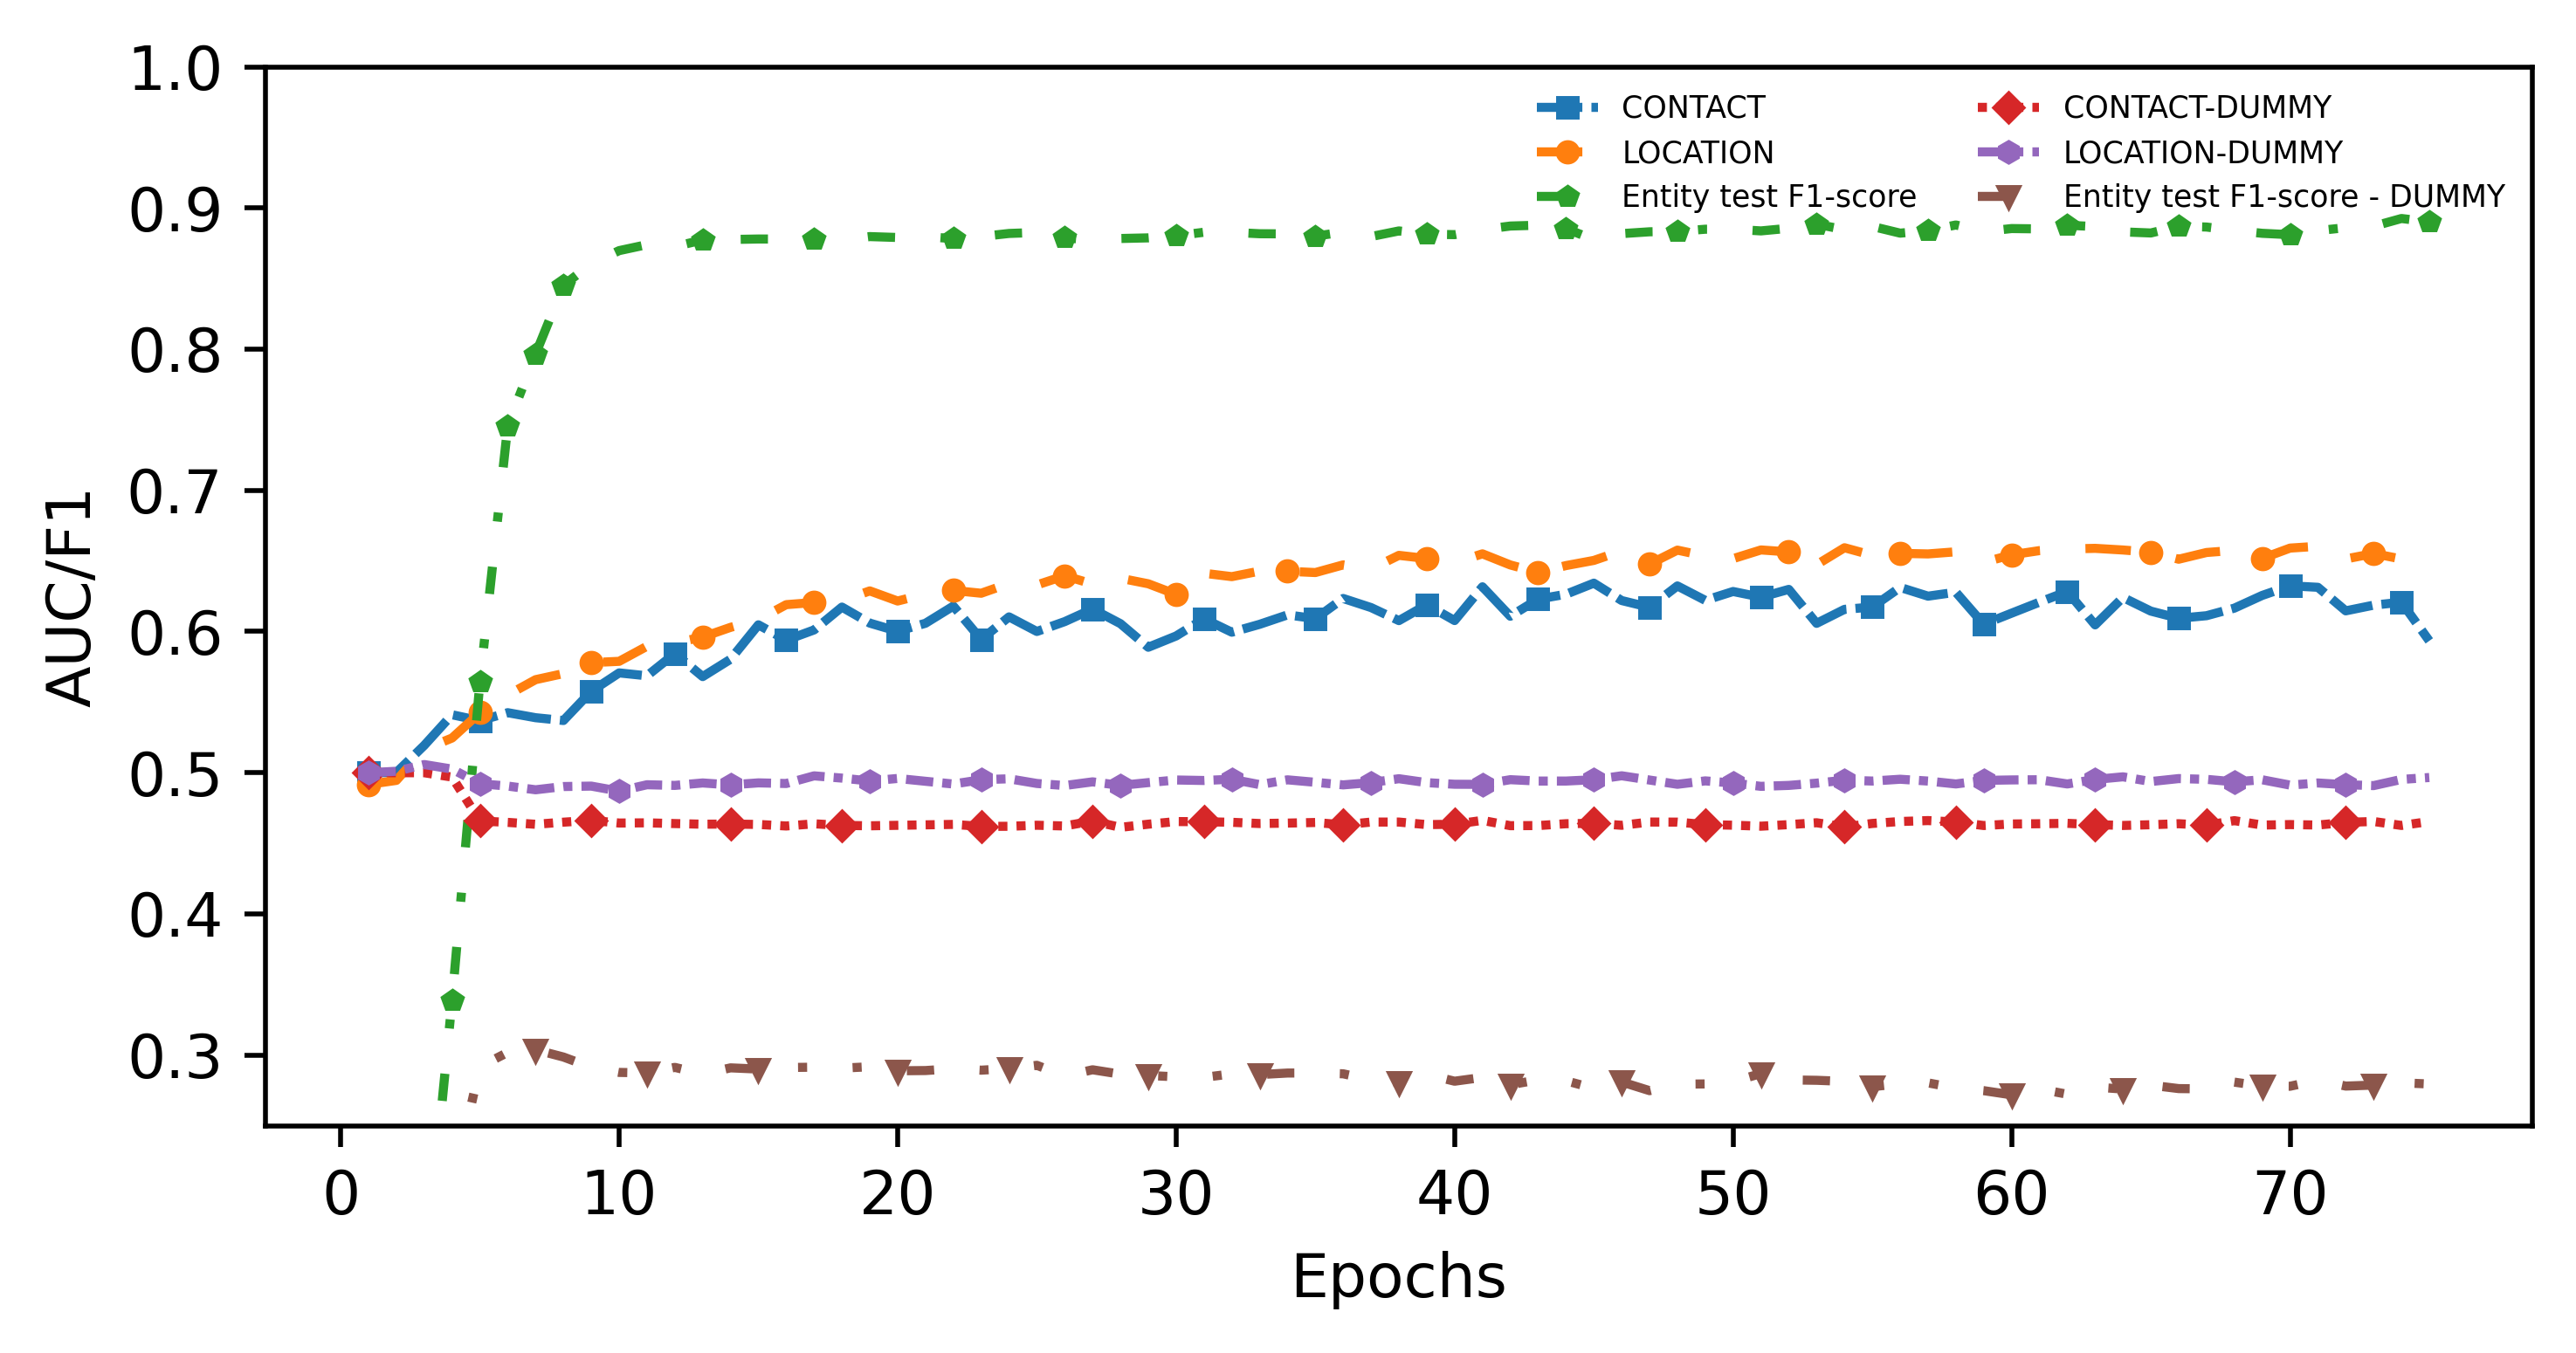

In [78]:
plt.figure(num=None, figsize=(6, 3.2), dpi=500, facecolor='w', edgecolor='k')
    
fig, ax1 = plt.subplots(num=None, figsize=(6, 3.2), dpi=500, facecolor='w', edgecolor='k')

marker_size = 3
mark_every = 0.05


linestyles_dict = OrderedDict(
[('solid',               (0, ())),
    ('loosely dotted',      (0, (1, 10))),
    ('dotted',              (0, (1, 5))),
    ('densely dotted',      (0, (1, 1))),

    ('loosely dashed',      (0, (5, 10))),
    ('dashed',              (0, (5, 5))),
    ('densely dashed',      (0, (5, 1))),

    ('loosely dashdotted',  (0, (3, 10, 1, 10))),
    ('dashdotted',          (0, (3, 5, 1, 5))),
    ('densely dashdotted',  (0, (3, 1, 1, 1))),

    ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
    ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
    ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))])

lines = ["-","--","-.",":", 'None']
linestype = itertools.cycle(("densely dashed", "dashed", "dashdotted", "densely dotted", "densely dashdotted", "dashdotdotted", "solid"))
marker = itertools.cycle(('s', 'o', 'p', 'D', 'h', 'v', '^', '>', '<', '1')) 
plts_label = []
for plots in plt_list:
    for plot in plots:
        print(plot)
        label = plot[0]
        line = plot[1][0]
        epochs, aucs = line.get_data()
        pl = ax1.plot(epochs, aucs, next(marker), label=label, markevery=mark_every, markersize=marker_size, linestyle=linestyles_dict[next(linestype)])
        plts_label.extend(pl)
    
ax1.set_ylabel("AUC/F1")
ax1.set_xlabel("Epochs")

ax1.set_ylim([0.25, 1])

print(plts_label)
labs = [l.get_label() for l in plts_label]

ax1.legend(plts_label, labs, loc="upper right", ncol=2, frameon=False, prop={'size': 5})

fig.tight_layout()
plt_folder = "../Results/MIA_Results_PLOTS/CONTACT-LOCATION-DUMMY_TRAINING_MEMBERSET_ORIGNIAL_VS_DUMMY/"
mkdir_p(plt_folder)
plt_dest = plt_folder + 'AUC_CONTACT-LOCATION-ORIGINAL_VS_DUMMY_i2b2_n2c2_dataset.pdf'
plt.savefig(plt_dest,
        bbox_inches="tight")

NameError: name 'ax1' is not defined

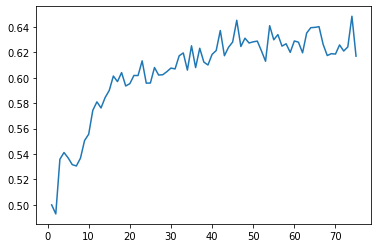

In [51]:
for plot in plt_list:
    for line in plot[1]:
        x, y = line.get_data()
        plt.plot(x, y)
        line.get_label()
        ax1.legend(plts, labs, loc="lower right", ncol=2, frameon=False, prop={'size': 8})
# plt.plot(plt_list[0])

# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.add_line(plt_list[0])
# plt.show()

In [36]:
y

array([0.00000000e+00, 4.98615026e-04, 1.32170665e-01, 3.29772785e-01,
       5.50832155e-01, 7.25187308e-01, 8.04234019e-01, 8.38858145e-01,
       8.58359977e-01, 8.66507540e-01, 8.69990716e-01, 8.68453376e-01,
       8.71897510e-01, 8.77083519e-01, 8.76621583e-01, 8.78658030e-01,
       8.78555335e-01, 8.78824829e-01, 8.80475184e-01, 8.79055352e-01,
       8.77731184e-01, 8.80068252e-01, 8.78480701e-01, 8.76461203e-01,
       8.79162744e-01, 8.80488545e-01, 8.75833857e-01, 8.79905021e-01,
       8.79593986e-01, 8.78959592e-01, 8.78091776e-01, 8.77857644e-01,
       8.78136703e-01, 8.76257584e-01, 8.80554369e-01, 8.82791306e-01,
       8.78940513e-01, 8.78767065e-01, 8.77194118e-01, 8.76725765e-01,
       8.83836988e-01, 8.82716149e-01, 8.80314326e-01, 8.83297221e-01,
       8.78662642e-01, 8.84139886e-01, 8.80754461e-01, 8.79782196e-01,
       8.82229334e-01, 8.78018436e-01, 8.78073059e-01, 8.80244355e-01,
       8.84601466e-01, 8.76664163e-01, 8.80885034e-01, 8.82546712e-01,
      

In [106]:
res_folder = "Results/FINAL_PLOTS/SECRET_TYPE_RANK_PER_EPOCH_RESULTS/"

g = unpack_data(res_folder)

RANK_PER_EPOCH_AND_INSERTION_AVERAGED_LINE_PLOT_spacy3.0.3_credit_card_numbers.pickle
RANK_PER_EPOCH_AND_INSERTION_AVERAGED_LINE_PLOT_spacy3.0.3_ip_addresses.pickle
RANK_PER_EPOCH_AND_INSERTION_AVERAGED_LINE_PLOT_spacy3.0.3_passwords.pickle
RANK_PER_EPOCH_AND_INSERTION_AVERAGED_LINE_PLOT_spacy3.0.3_phone_numbers.pickle
Read Disk
4 TEST RUNS FOUND


In [69]:
len(g[0][1])

74

In [25]:
epoch_scores[0][0][1]

[0.7493457943925234, 0.350620955046353, 0.4777168732125835]

In [30]:
for subrun in range(len(scorer_scores)):
    epochs = [t[0] for t in scorer_scores[subrun]]
    secret_f1 = [t[1][2] for t in scorer_scores[subrun]]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 

In [16]:
total_epoch_scores = []
avg_epoch_scores = []

for subrun in range(len(epoch_scores)):
    epochs = [t[0] for t in epoch_scores[subrun]]
    f1 = [t[1][2] for t in epoch_scores[subrun]]
    avg_epoch_scores.append(f1)
avg_epoch_scores = [np.mean(np.array(t)) for t in list(zip(*avg_epoch_scores))]
total_epoch_scores.append(avg_epoch_scores)

In [18]:
total_epoch_scores

[[0.47410344458217357,
  0.6258984107976435,
  0.7594410899291046,
  0.8640914011282369,
  0.8973079359477403,
  0.9162599524889415,
  0.9256790985262393,
  0.9319234201984059,
  0.9351005009119682,
  0.9368967049175131,
  0.9375623601830455,
  0.9381343458843041,
  0.9386922641567033,
  0.9387759513040079,
  0.9391426203076906,
  0.939395911344653,
  0.9404523590070426,
  0.9398962500183536,
  0.9404572032326557,
  0.9411718026268584,
  0.9397340270356164,
  0.9400884217281741,
  0.9408199975965168,
  0.9400838609838361,
  0.9414444355960301,
  0.9412781733256654,
  0.9413940889925622,
  0.940538283044209,
  0.9410322313189396,
  0.9416335777133538,
  0.9407496198510756,
  0.9408503714595182,
  0.9413147822659671,
  0.9417303366525308,
  0.9411625317168664,
  0.9429476495899562,
  0.9414011331928196,
  0.9421269154037983,
  0.9420020653227399,
  0.9418555273128779,
  0.9423031798645365,
  0.9422327991841192,
  0.9421795249950426,
  0.9430170550075972,
  0.9414695561979428,
  0.9415977

In [24]:
import seaborn as sns

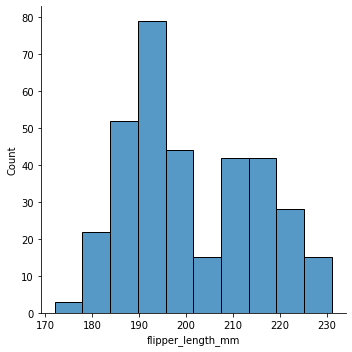

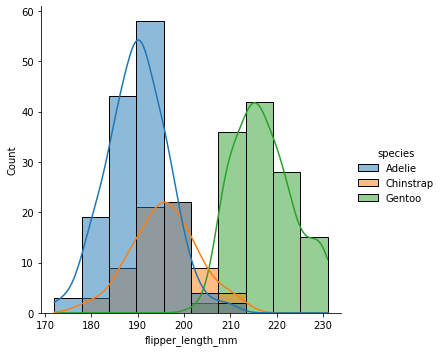

In [28]:
penguins = sns.load_dataset("penguins")
sns.displot(penguins, x="flipper_length_mm")
sns.displot(penguins, x="flipper_length_mm", hue="species", fill=True, kde=True)